# Stackshot combine

I used CombineZP software to combine the fungus stackshot images. While the combining works fine, the batch process is a pain, because the software keeps popping up to the front and interrupts other software. What's more, if it runs into an error, it gets stuck there forever, until I click on the button. It also gives weird results sometimes, and since I don't have a full grisp on its working principles, it is difficult to pinpoint the problem and fix it. These facts motivate me to write a python software to combine the stackshot, in the hope to make this process more flexible.  

In [45]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage.filters import sobel

In [73]:
# Function to calculate the sharpness measure
def sharpness_measure(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

# Function to align images
def align_images(images):
    # Convert base image to grayscale if it's not already
    base_image = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
    aligned_images = [images[0]]

    for image in images[1:]:
        # Convert current image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Initialize the warp matrix to identity
        warp_matrix = np.eye(2, 3, dtype=np.float32)

        # Define the motion model (Affine)
        number_of_iterations = 5000
        termination_eps = 1e-10

        # Define termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations, termination_eps)

        # Perform the ECC image alignment
        (cc, warp_matrix) = cv2.findTransformECC(base_image, gray_image, warp_matrix, cv2.MOTION_TRANSLATION, criteria)

        # Warp the current image to align with the base image
        aligned_image = cv2.warpAffine(image, warp_matrix, (base_image.shape[1], base_image.shape[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        aligned_images.append(aligned_image)
    
    return aligned_images

In [74]:
# Path to the folder containing the stack images
path = r'F:\F\07302024\exp1\stack0000\*.jpg'  # Update this to match your image files

# Read and align images
images = [cv2.imread(file) for file in glob.glob(path)]
aligned_images = align_images(images)


In [75]:

# Initialize an array to hold the sharpest image at each pixel
sharpest_image = np.zeros_like(images[0], dtype=np.float32)

# Initialize an array to hold the sharpness values
sharpness_values = np.zeros((len(images), images[0].shape[0], images[0].shape[1]))


In [76]:
# Calculate sharpness for each pixel in each image
for i, image in enumerate(aligned_images):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sharpness_values[i] = sobel(gray_image)

# Determine the sharpest pixel for each position
sharpest_indices = np.argmax(sharpness_values, axis=0)

# Construct the sharpest image by selecting pixels from the sharpest images
for i in range(len(aligned_images)):
    mask = (sharpest_indices == i)
    sharpest_image[mask] = aligned_images[i][mask]

# Convert the sharpest image to uint8
sharpest_image = sharpest_image.astype(np.uint8)

# Post-processing: Apply denoising and sharpening
# sharpest_image = cv2.fastNlMeansDenoising(sharpest_image, None, 10, 7, 21)
# kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
# sharpest_image = cv2.filter2D(sharpest_image, -1, kernel)

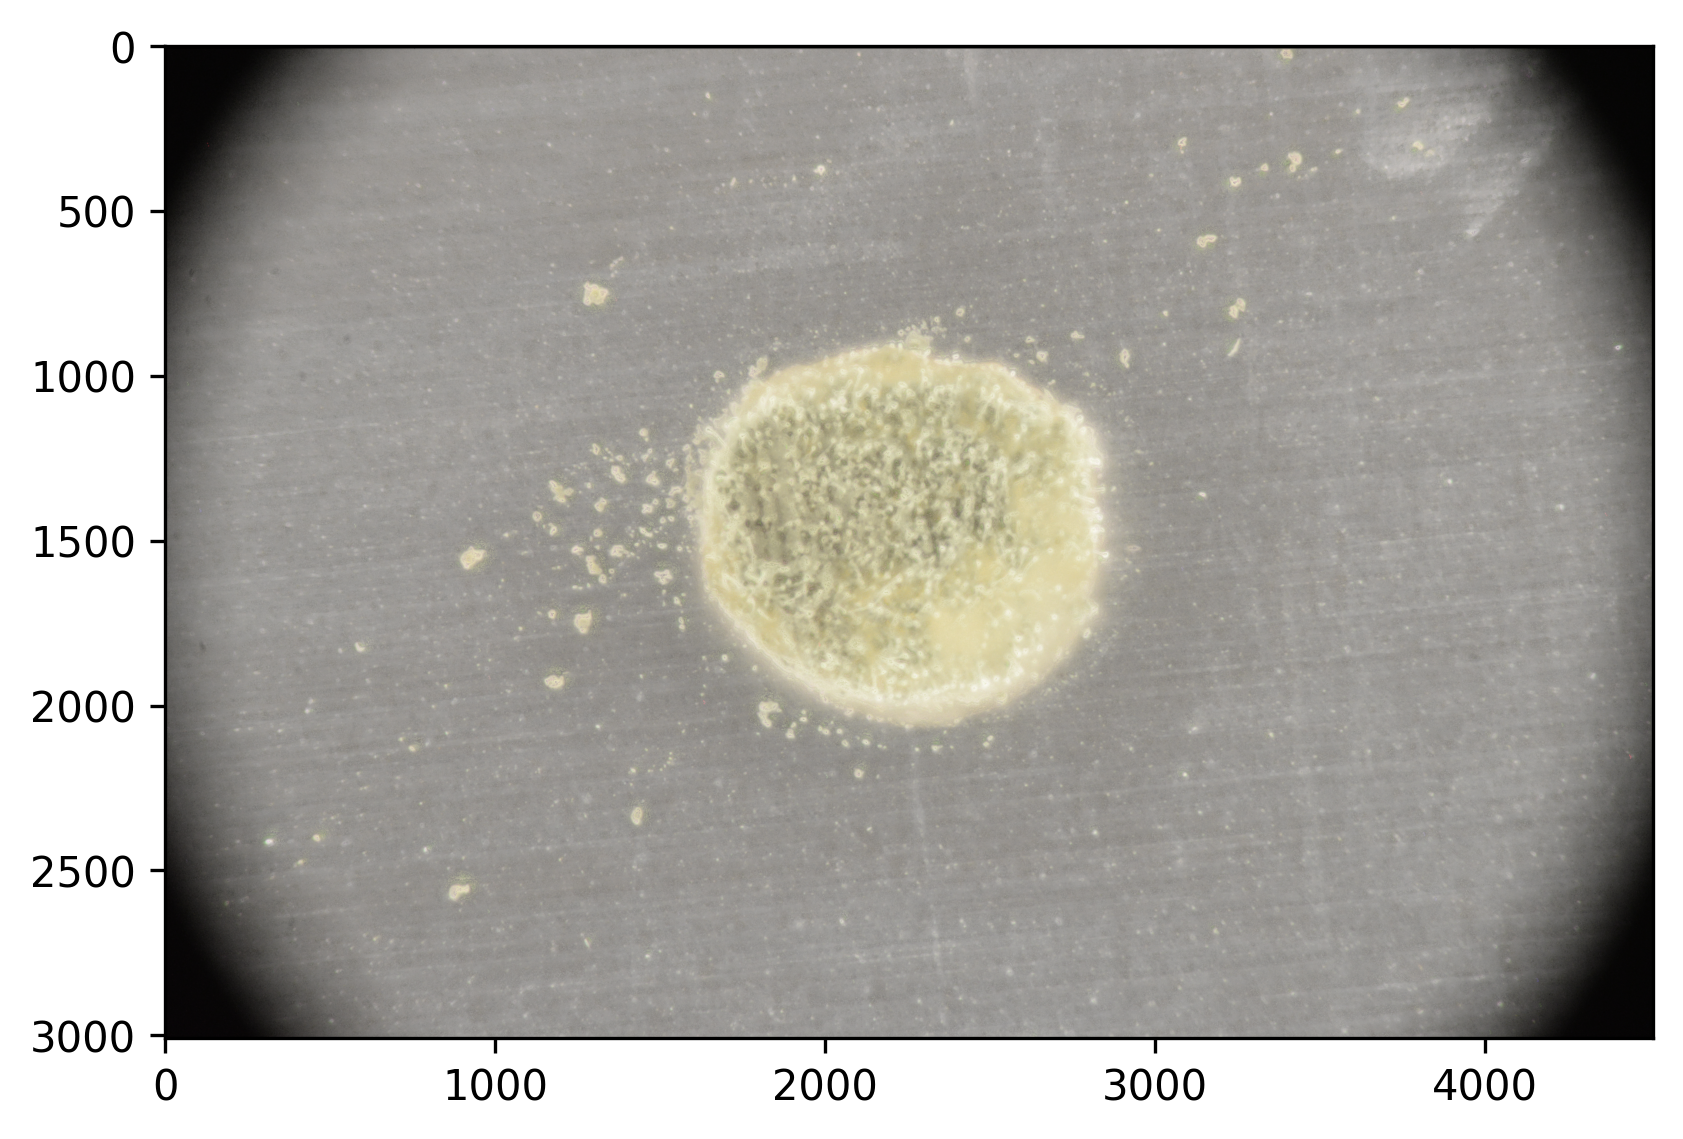

In [81]:
plt.figure(dpi=300)
s = cv2.cvtColor(sharpest_image, cv2.COLOR_BGR2RGB)
plt.imshow(s)

The resulting stacked image is less sharp compared to the one made by CombineZP, so ...

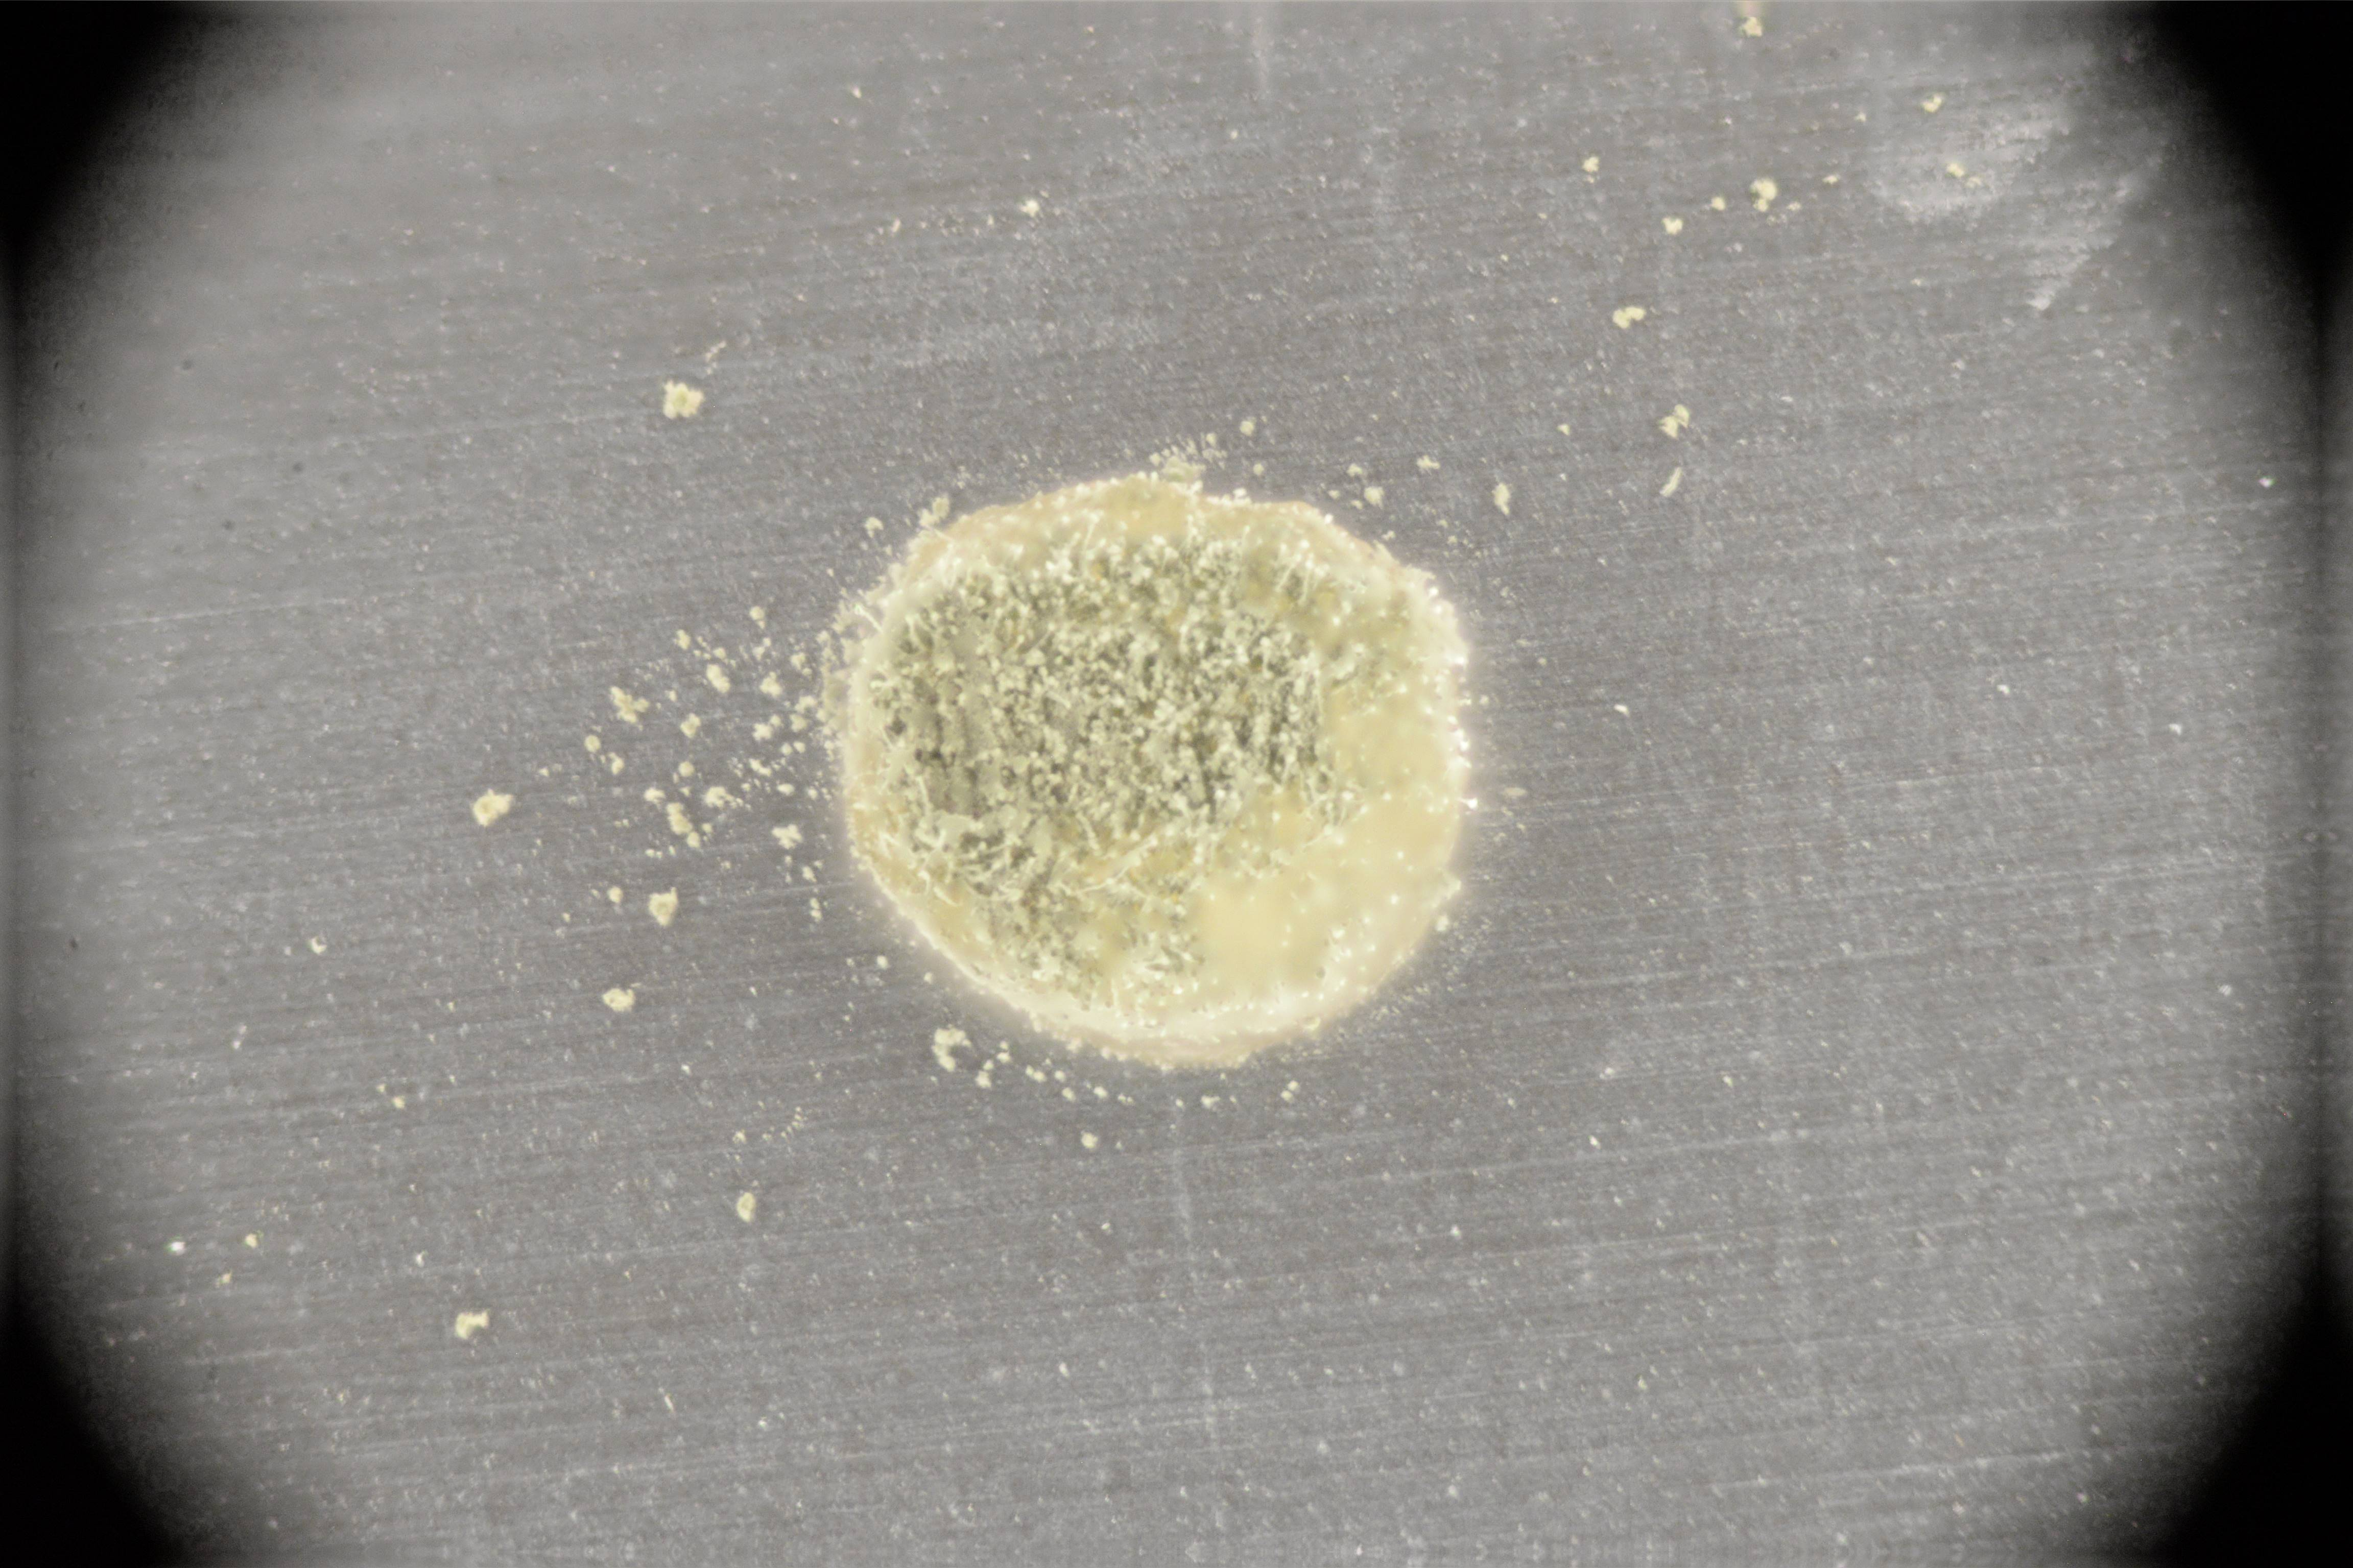